In [ ]:
!pip install opencv-python==4.8.0.74
!pip install open3d

In [205]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from PIL import Image
import cv2
import os
import open3d as o3d



In [1]:

#необходимо узнать размер изобрадения для получения значений cx=width/2 cy=hight/2 
image_path = r"C:\Users\Wdtum\Downloads\TestTaskSFM\TestTaskSFM\site_capture\1.jpg"
image = Image.open(image_path)

# Получаем размер изображения
width, height = image.size
cx=width/2
cy=height/2
print(f"Ширина: {width}, Высота: {height}")
print(cx,cy)

Ширина: 6528, Высота: 3264
3264.0 1632.0


In [120]:
def feature_extraction_and_matching(img1, img2):
    

    # Инициализация детектора и дескриптора
    #orb = cv2.ORB_create()
    sift = cv2.SIFT_create()
    # Обнаружение ключевых точек и вычисление дескрипторов
    #kp1, des1 = orb.detectAndCompute(img1, None)
    #kp2, des2 = orb.detectAndCompute(img2, None)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Сопоставление дескрипторов orb
    #bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    #matches = bf.match(des1, des2)
    
    #Сопоставление дескрипторов sift
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1,des2)

    # Сортировка соответствий по расстоянию
    matches = sorted(matches, key=lambda x: x.distance)

    return kp1, kp2, matches


In [130]:

def reconstruct_3d(kp1, kp2, matches, K):
    # ... (код для восстановления 3D точек из предыдущих ответов)
    """
    Восстановление 3D точек.

    Args:
        kp1: Ключевые точки первого изображения.
        kp2: Ключевые точки второго изображения.
        matches: Соответствия между ключевыми точками.
        K: Матрица внутренней калибровки камеры.
    """

    # Выбор точек, для которых есть соответствия
    points1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    E, mask = cv2.findEssentialMat(points1, points2, K)
    _, R, t, mask = cv2.recoverPose(E, points1, points2, K)
    proj_matrix1 = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
    proj_matrix2 = np.hstack((R, t))

    # Convert to homogeneous coordinates
    proj_matrix1 = K @ proj_matrix1
    proj_matrix2 = K @ proj_matrix2
    # Триангуляция
    points_4d_hom = cv2.triangulatePoints(proj_matrix1, proj_matrix2, points1, points2)
    points_3d = points_4d_hom[:3, :] / points_4d_hom[3, :]

    return points_3d,R,t

In [144]:
def plot_3d_points(points_3d):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
    plt.show()

0


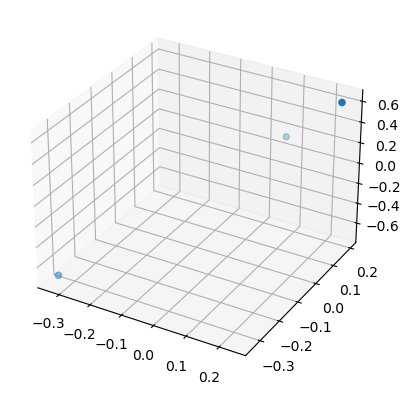

1


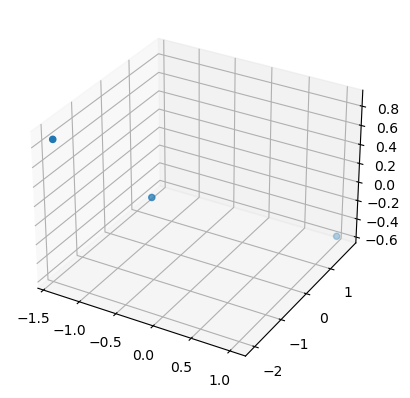

2


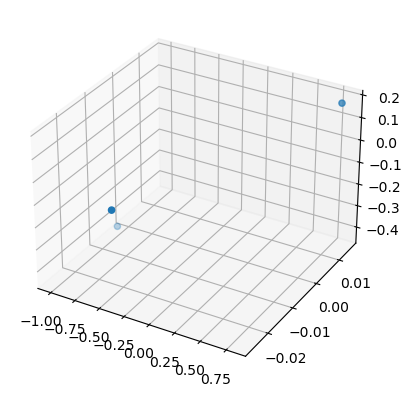

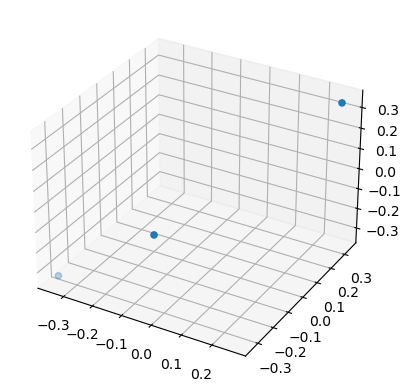

In [211]:
#параметры камеры
cx=5984
cy=2992
fx=2394
fy=2394
#2394


# Загрузка изображений
image_dir = r"C:\Users\Wdtum\Downloads\TestTaskSFM\TestTaskSFM\site_capture"
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]

# Калибровка камеры (предположим, что матрица камеры K и внешние параметры R, t известны)

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

# Создание списка для хранения 3D точек, матриц поворота, перемещений
all_points3D = []
allR=[]
allt=[]


# Проход по всем парам изображений

for i in range(len(images)-1):
    #print(f"Сравниваем {img1} с {img2}")
    img1 = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(images[i+1], cv2.IMREAD_GRAYSCALE)
    
        
    print(i)
    kp1, kp2, matches = feature_extraction_and_matching(img1, img2)
    points3D,R,t = reconstruct_3d(kp1, kp2, matches, K)
    plot_3d_points(points3D)
    all_points3D.append(points3D)
    allR.append(R)
    allt.append(t)
    
    
    if i==2:
        img1 = cv2.imread(images[3], cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(images[1], cv2.IMREAD_GRAYSCALE)
        kp1, kp2, matches = feature_extraction_and_matching(img1, img2)
        points3D,R,t = reconstruct_3d(kp1, kp2, matches, K)
        plot_3d_points(points3D)
        all_points3D.append(points3D)
        allR.append(R)
        allt.append(t)
        
     

 

In [209]:
# Объединение всех 3D точек
all_points3D = np.concatenate(all_points3D, axis=1)

# Создание облака точек
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(all_points3D.T)

# Визуализация
o3d.visualization.draw_geometries([pcd])

In [210]:
# сохранение облака точек
o3d.io.write_point_cloud("point_cloud.ply", pcd) 



True

отрисовка траектории камеры и расчет углов

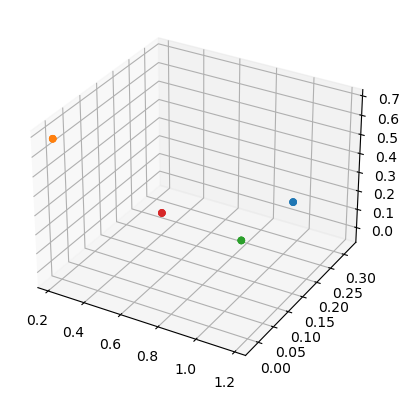

In [174]:
# отрисовка движения траектории
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Инициализация позиции камеры
camera_pos = np.zeros(3)
allR=np.array(allR)
allt=np.array(allt)
points=[]
angles=[]
for R, t in zip(allR, allt):
    camera_pos = camera_pos+np.dot(R, t)
    rot_vec, _ =cv2.Rodrigues(R)
    angle=rot_vec * 180 / np.pi
    ax.scatter(camera_pos[0], camera_pos[1], camera_pos[2])
    points.append(camera_pos)
    angles.append(angle)
    

plt.show()

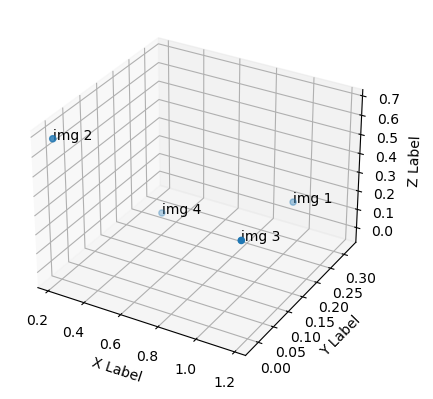

In [169]:

# Ваши массивы с координатами
points=points

# Извлечение координат x, y, z
x = [point[0][0] for point in points]
y = [point[1][0] for point in points]
z = [point[2][0] for point in points]

# Создание 3D графика
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)  # s - размер точек, color - цвет
for i, point in enumerate(points):
    ax.text(point[0][0], point[1][0], point[2][0], f'img {i + 1}', size=10, zorder=1)
    # Настройка меток осей
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')# Clear the current axis
   


plt.show()

углы поворота камеры


In [180]:
 print(angles[0][1])

[142.66112111]


In [177]:
 print(angles[1])

[[0.22706745]
 [4.0532735 ]
 [3.70323885]]


In [178]:
 print(angles[2])

[[ -9.95525613]
 [-11.90724083]
 [ -3.78385565]]


In [179]:
 print(angles[3])

[[  0.93349254]
 [-89.38867004]
 [-49.541995  ]]


создание датафрейма

In [199]:
data={'x':[points[0][0][0],points[1][0][0],points[2][0][0],points[3][0][0]],
     'y':[points[0][1][0],points[1][1][0],points[2][1][0],points[3][1][0]],
     'z':[points[0][2][0],points[1][2][0],points[2][2][0],points[3][2][0]],
     'angle1':[angles[0][0][0],angles[1][0][0],angles[2][0][0],angles[3][0][0]],
     'angle2':[angles[0][1][0],angles[1][1][0],angles[2][1][0],angles[3][1][0]],
     'angle3':[angles[0][2][0],angles[1][2][0],angles[2][2][0],angles[3][2][0]]}

In [200]:
df=pd.DataFrame(data)

In [201]:
df

,x,y,z,angle1,angle2,angle3
0,0.943444,0.320271,0.085673,-52.325968,142.661121,26.344328
1,0.213297,-0.016671,0.680110,0.227067,4.053273,3.703239
2,1.184649,-0.014289,0.442478,-9.955256,-11.907241,-3.783856
3,0.339781,0.237675,-0.029445,0.933493,-89.388670,-49.541995


In [202]:
df.to_csv('camera.csv', index=False)